In [2]:
!pip install pytorch_metric_learning
!pip install faiss-gpu

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/Jiarong"
os.chdir(path)

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers,regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import math
import json
from sklearn.model_selection import train_test_split
import pandas as pd
import jieba
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score,f1_score
from tensorflow.keras.layers import concatenate
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.utils import common_functions as c_f
from pytorch_metric_learning.utils.inference import InferenceModel, MatchFinder
import operator as opt

torch.set_default_tensor_type(torch.DoubleTensor)

SEED = 30

torch.manual_seed(SEED) 
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True 

embedding_size = 300
sequence_length = 5000
num_classes = 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
f = open("./data/url+text/longtext.txt",encoding='utf-8')   
label,text = [],[]
for line in f:
  values = line.split()
  label.append(int(values[0]))
  text.append(values[1:])
print(len(text))
print(text[0])

f = open("./data/url+text/url_0416.txt",encoding='utf-8')   
url = []
for line in f:
  url.append(line)
print(len(url))
print(url[0])

19326
['手机', '知网', 'App', '24', '小时', '专家级', '知识', '服务', '开', '石油', '天然气', '工业', '黄铁矿', '龙口', '油页岩', '热解', '影响', '哈尔滨工业大学', '闫永宏', '面对', '石油', '需求', '与日俱增', '动荡', '国际局势', '提高', '石油', '自给', '比例', '降低', '对外', '依存度', '国家', '发展', '意义', '油页岩', '一种', '非常规', '能源', '干馏', '类似', '石油', '原油', '页岩', '油', '分离', '改善', '油品', '有望', '汽油', '柴油', '油', '开发利用', '油页岩', '缓解', '我国', '石油', '紧张局势', '意义', '油页岩', '中', '含有', '矿物质', '油页岩', '热分解', '影响', '黄铁矿', '干馏', '过程', '中', 'H2S', '含硫', '气体', '污染环境', '腐蚀', '设备', '探究', '内在', '矿物质', '黄铁矿', '油页岩', '热解', '中', '影响', '作用', '清洁', '高效', '利用', '页岩', '油', '提供', '理论指导', '油页岩', '原样', '脱灰后', '干酪根', '温度', '固定床', '热解', '实验', '借助', 'FTIR', 'GC', 'MS', '分析', '手段', '温度', '产物', '产率', '半焦', '化学', '结构', '页岩', '油', '特性', '分析', '油页岩', '热解', '特性', '矿物质', '热解', '过程', '影响', '结果表明', '温度', '升高', '油页岩', '转化率', '升高', '干酪', '最佳', '产油', '率', '温度', '490', '矿物质', '时该', '温度', '提高', '520', '页岩', '油', '生成', '矿物质', '脂肪', '族长', '链', '甲基', '侧链', '断裂', '环状', '结构', '生成', '氧', '脱除', '促进作用', '干酪', '高温', '芳'

In [ ]:
cnt = 0
for i in label:
  if i == 1:
    cnt += 1
cnt

9661

In [5]:
max_num_words_text = 30000
tokenizer=Tokenizer(num_words=max_num_words_text,lower=True,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~� ',oov_token='<OOV>')
tokenizer.fit_on_texts(text)
vocab_text={word:i+1 for i, word in enumerate(tokenizer.word_index) if i+1<max_num_words_text}

from gensim.models import Word2Vec
#w2v_model = Word2Vec(sentences=x_train0, size=300, window=5, min_count=1, workers=4)
#w2v_model.save("w2v_model.model")
w2vmodel = Word2Vec.load("w2v_model.model")
embedding_matrix_text = np.zeros((len(vocab_text) + 1, 300))
for word, i in vocab_text.items():
    try:
        embedding_vector = w2vmodel.wv[str(word)]
        embedding_matrix_text[i] = embedding_vector
    except KeyError:
        continue
embedding_matrix_text = torch.from_numpy(embedding_matrix_text)
embedding_matrix_text.shape

torch.Size([30000, 300])

In [ ]:
max_num_words_url = 10000
tokenizer=Tokenizer(num_words=max_num_words_url,lower=True,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~� ',oov_token='<OOV>')
tokenizer.fit_on_texts(url)
vocab_url={word:i+1 for i, word in enumerate(tokenizer.word_index) if i+1<max_num_words_url}

urlmodel = Word2Vec(sentences=url, size=300, window=5, min_count=1, workers=4)
embedding_matrix_url = np.zeros((len(vocab_url) + 1, 300))
for word, i in vocab_url.items():
    try:
        embedding_vector = urlmodel.wv[str(word)]
        embedding_matrix_url[i] = embedding_vector
    except KeyError:
        continue
embedding_matrix_url = torch.from_numpy(embedding_matrix_url)
embedding_matrix_url.shape

torch.Size([10000, 300])

In [ ]:
embedding_matrix = torch.cat((embedding_matrix_text, embedding_matrix_url), 0)
embedding_matrix.shape

torch.Size([40000, 300])

In [6]:
text_sequence_length, url_sequence_length = 5000, 18

rootdata = pad_sequences(tokenizer.texts_to_sequences(text), maxlen=text_sequence_length)
#rootdata = np.concatenate([pad_sequences(tokenizer.texts_to_sequences(text), maxlen=text_sequence_length), pad_sequences(tokenizer.texts_to_sequences(url), maxlen=url_sequence_length)],axis=1)
rootdata.shape

(19326, 5000)

In [7]:
class TextDataset(Data.Dataset):
    """LongText2000 dataset."""

    def __init__(self, data_root, data_label):
        self.data = data_root
        self.label = data_label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        labels = self.label[index]
        return data, labels

In [8]:
torch_data = TextDataset(rootdata, label)

train_size = int(len(torch_data) * 0.6)
validate_size = int(len(torch_data) * 0.2)
test_size = len(torch_data) - train_size - validate_size
train_set, valid_set, test_set = Data.random_split(torch_data, [train_size, validate_size, test_size])


train_loader = Data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=False, num_workers=4, pin_memory=True)
print(len(train_loader))

363


In [9]:
# text和url信息在输入特征层合并
class textCNN(nn.Module):
    def __init__(self):
        super(textCNN, self).__init__()
        Knum = 256 
        Ks = [3,4,5]
        
        self.embed = nn.Embedding(len(vocab_text)+1, embedding_size, _weight = embedding_matrix_text) 
        
        self.convs = nn.ModuleList([nn.Conv2d(1,Knum,(K,embedding_size)) for K in Ks])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(Ks)*Knum,128) 
        
    def forward(self,x):
        x = self.embed(x) #(N,W,D)
        x = x.unsqueeze(1) #(N,Ci,W,D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs] # len(Ks)*(N,Knum,W)
        x = [F.max_pool1d(line,line.size(2)).squeeze(2) for line in x]  # len(Ks)*(N,Knum)
        
        x = torch.cat(x,1) #(N,Knum*len(Ks))
        
        x = self.dropout(x)
        logit = self.fc(x)
        return logit

if hasattr(torch.cuda, 'empty_cache'):
	  torch.cuda.empty_cache()

In [ ]:
# text和url信息在线性层合并
class textCNN(nn.Module):
    def __init__(self):
        super(textCNN, self).__init__()
        # textCNN
        Knum1 = 256 
        Ks1 = [3,4,5]
        
        #self.embed = nn.Embedding(len(vocab_text)+len(vocab_url)+2, embedding_size, _weight=embedding_matrix) 
        self.text_embed = nn.Embedding(len(vocab_text)+1, embedding_size, _weight=embedding_matrix_text)

        self.text_convs = nn.ModuleList([nn.Conv2d(1,Knum1,(K,embedding_size)) for K in Ks1])
        self.dropout = nn.Dropout(0.5)

        # urlCNN
        Knum2 = 64
        Ks2 = [2,3,4]

        self.url_embed = nn.Embedding(len(vocab_url)+1, embedding_size, _weight=embedding_matrix_url)
        self.url_convs = nn.ModuleList([nn.Conv2d(1,Knum2,(K,embedding_size)) for K in Ks2])
        
        self.fc = nn.Linear(len(Ks1)*Knum1+len(Ks2)*Knum2, 128)

        
    def forward(self,x):
        x_text, x_url = torch.split(x, [text_sequence_length, url_sequence_length], dim=1)

        # text
        x_text = self.text_embed(x_text) #(N,W,D)
        x_text = x_text.unsqueeze(1) #(N,Ci,W,D)
        x_text = [F.relu(conv(x_text)).squeeze(3) for conv in self.text_convs] # len(Ks)*(N,Knum,W)
        x_text = [F.max_pool1d(line,line.size(2)).squeeze(2) for line in x_text]  # len(Ks)*(N,Knum)
        x_text = torch.cat(x_text,1) #(N,Knum*len(Ks))
        x_text = self.dropout(x_text)

        # url
        x_url = self.url_embed(x_url) #(N,W,D)
        x_url = x_url.unsqueeze(1) #(N,Ci,W,D)
        x_url = [F.relu(conv(x_url)).squeeze(3) for conv in self.url_convs] # len(Ks)*(N,Knum,W)
        x_url = [F.max_pool1d(line,line.size(2)).squeeze(2) for line in x_url]  # len(Ks)*(N,Knum)
        x_url = torch.cat(x_url,1) #(N,Knum*len(Ks))
        x_url = self.dropout(x_url)

        x = torch.cat((x_text,x_url), 1)
        logit = self.fc(x)

        return logit

In [10]:
def train(model, loss_func, mining_func, train_loader, train_set, valid_set, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.cuda(), labels.cuda()
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        print(
            "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                epoch, batch_idx, loss, mining_func.num_triplets
            )
        )
    model.eval()
    best_acc = 0
    with torch.no_grad():
        train_embeddings, train_labels = get_all_embeddings(train_set, model)
        valid_embeddings, valid_labels = get_all_embeddings(valid_set, model)
        train_labels = train_labels.squeeze(1)
        valid_labels = valid_labels.squeeze(1)
        train_embeddings = train_embeddings.cpu()
        valid_embeddings = valid_embeddings.cpu()
        train_labels = train_labels.cpu()
        valid_labels = valid_labels.cpu()
        accuracies = accuracy_calculator.get_accuracy(
            valid_embeddings, train_embeddings, valid_labels, train_labels, False
        )
        acc = accuracies["precision_at_1"]
        if best_acc < acc:
            best_acc = acc
            torch.save(model.state_dict(), 'no_merge.pt')
        print("Valid set accuracy (Precision@1) = {}".format(acc))

In [11]:
### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

In [12]:
### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    train_embeddings = train_embeddings.cpu()
    test_embeddings = test_embeddings.cpu()
    train_labels = train_labels.cpu()
    test_labels = test_labels.cpu()

    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print("Test set accuracy (r_precision) = {}".format(accuracies["r_precision"]))

In [13]:
EPOCH = 5
model = textCNN().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)

accuracy_calculator = AccuracyCalculator(
    include=(
        "mean_average_precision",
        "precision_at_1",
        "r_precision",
        "mean_average_precision_at_r",
    ),
    k="max_bin_count"
)
### pytorch-metric-learning stuff ###

In [ ]:
for epoch in range(EPOCH):
    train(model, loss_func, mining_func, train_loader, train_set, valid_set, optimizer, epoch)

In [ ]:
model = textCNN().cuda()
embeddings_before, train_labels = get_all_embeddings(train_set, model)

model.load_state_dict(torch.load('merge@linear_layer.pt'))
embeddings_after, train_labels = get_all_embeddings(train_set, model)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


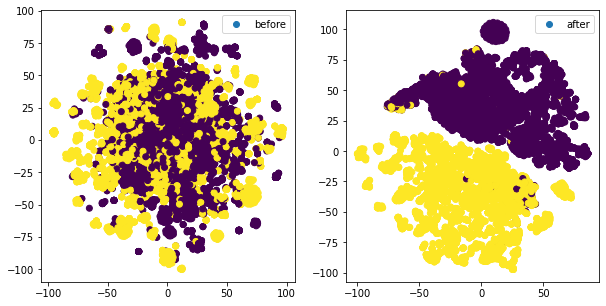

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

embeddings_before = embeddings_before.cpu().numpy()
embeddings_after = embeddings_after.cpu().numpy()
train_labels = train_labels.cpu().numpy()

X_before = TSNE(n_components=2, random_state=33).fit_transform(embeddings_before)
X_after = TSNE(n_components=2, random_state=33).fit_transform(embeddings_after)

ckpt_dir="images"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_before[:, 0], X_before[:, 1], c=train_labels, label="before")
plt.legend()
plt.subplot(122)
plt.scatter(X_after[:, 0], X_after[:, 1], c=train_labels, label="after")
plt.legend()
plt.savefig('images/digits_tsne.png', dpi=120)
plt.show()

In [14]:
model.load_state_dict(torch.load('triplet_loss_0426_1.pt'))
test(train_set, test_set, model, accuracy_calculator)

100%|██████████| 121/121 [02:34<00:00,  1.28s/it]
Using CPU for k-nn search because k = 5858 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (r_precision) = 0.9369256284349624


In [ ]:
def cleanurl(line):
    line = delgoogleweblight(line)
    whiteurlparts = ['/', '.', ':']
    comp = []
    for i in list(filter(bool, re.split('([^a-zA-Z])',line))):
        if i in whiteurlparts or len(i)>=2:
          comp.append(i)
    return comp

def delgoogleweblight(url):
    a = url.strip().split('/')
    if a[2]=='googleweblight.com':
        a.remove('')
        a.remove('googleweblight.com')
        a.remove('fp?u='+a[0])
        return '/'.join(a)
    else:
        return url

In [15]:
f = open("data/finaltest_text.txt",encoding='utf-8')   
text_test,test_label = [],[]
for line in f:
  values = line.split()
  text_test.append(values)
  test_label.append(0)
print(len(text_test))

f = open("data/finaltest_url.txt",encoding='utf-8')   
url_test = []
for line in f:
  line = line.split()
  url_test.append(line)

300


In [16]:
df_url = pd.read_excel('./data/finaltest_url.xlsx')
urltripletL1 = df_url['url'].values.tolist()
df = pd.read_excel('./data/预测结果.xlsx')
urlannotation = df['url'].values.tolist()
annotation = df['annotation'].values.tolist()

annotation_dic = {}
for i in range(len(urlannotation)):
    annotation_dic[urlannotation[i]] = annotation[i]
print(len(annotation_dic))

test_label = []
for i in urltripletL1:
  test_label.append(annotation_dic[i])
print(test_label)

test_data = pad_sequences(tokenizer.texts_to_sequences(text_test), maxlen=text_sequence_length)
#test_data = np.concatenate([pad_sequences(tokenizer.texts_to_sequences(text_test), maxlen=text_sequence_length), pad_sequences(tokenizer.texts_to_sequences(url_test), maxlen=url_sequence_length)],axis=1)
data_test = TextDataset(test_data, test_label)

300
[0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In [ ]:
model.load_state_dict(torch.load('merge@linear_layer.pt'))

train_embeddings, train_labels = get_all_embeddings(train_set, model)
test_embeddings, test_labels = get_all_embeddings(data_test, model)
train_labels = train_labels.squeeze(1)
test_labels = test_labels.squeeze(1)
train_embeddings = train_embeddings.cpu()
test_embeddings = test_embeddings.cpu()
train_labels = train_labels.cpu()
test_labels = test_labels.cpu()

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


In [ ]:
print("Computing accuracy")
accuracies = accuracy_calculator.get_accuracy(
    test_embeddings, train_embeddings, test_labels, train_labels, False
)
print("Test set accuracy (precision_at_1)) = {}".format(accuracies["precision_at_1"]))

Using CPU for k-nn search because k = 5858 > 2048, which is the maximum allowable on GPU.


Computing accuracy
Test set accuracy (precision_at_1)) = 0.8500000000000001


In [18]:
model.load_state_dict(torch.load('triplet_loss_0426_1.pt'))
def kNN(dataset, labels, testdata, k):
    distSquareMat = (dataset - testdata) ** 2
    distSquareSums = distSquareMat.sum(axis=1) 
    distances = distSquareSums ** 0.5 
    sortedIndices = distances.argsort()  #array.argsort(),默认axis=0从小到大排序，得到排序后的下标位置
    indices = sortedIndices[:k] #取距离最小的k个值对应的小标位置
    p,n = 0,0
    for i in indices:
        label = labels[i]
        if label == 1:
          p += 1
        else:
          n += 1
    if p>n:
      return 1
    elif p<n:
      return 0
    else:
      return '无法区分'

In [19]:
train_x, train_y = get_all_embeddings(train_set, model)
train_x = train_x.cpu().numpy()
train_y = train_y.cpu().numpy()

100%|██████████| 363/363 [07:43<00:00,  1.28s/it]


In [20]:
test_x, test_y = get_all_embeddings(data_test, model)
test_x = test_x.cpu().numpy()
test_y = test_y.cpu().numpy()

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


In [21]:
cnt = 0
inputlayer = []
for i in test_x:
    result = kNN(train_x, train_y, i, 11)
    inputlayer.append(result)
    if result == 1:
      cnt += 1

print(cnt)

76


In [22]:
df_url = pd.read_excel('./data/finaltest_url.xlsx')
urltripletL1 = df_url['url'].values.tolist()
df = pd.read_excel('./data/预测结果.xlsx')
urlannotation = df['url'].values.tolist()
annotation = df['annotation'].values.tolist()
logistic = df['logistic'].values.tolist()

annotation_dic, pred_dic = {},{}
for i in range(len(urlannotation)):
    annotation_dic[urlannotation[i]] = annotation[i]
print(len(annotation_dic))

for i in range(len(urltripletL1)):
    pred_dic[urltripletL1[i]] = inputlayer[i]
print(len(pred_dic))

300
300


In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_label, inputlayer)

array([[201,  31],
       [ 23,  45]])

In [ ]:
url_final, annotation_final, pred_final=[],[],[]
cnt = 0
for i in annotation_dic:
    url_final.append(i)
    annotation_final.append(annotation_dic[i])
    pred_final.append(pred_dic[i])
    if annotation_dic[i] == pred_dic[i]:
        cnt += 1
print(cnt)

224


In [ ]:
whitea = pd.DataFrame({'url':url_final,'annotation':annotation_final,'logistic':logistic,'TextCNN_linear':pred_final})
writer = pd.ExcelWriter('./data/预测结果1.xlsx')
whitea.to_excel(writer,index=None)
writer.save()